## Жёлтое такси в Нью-Йорке. Часть 1.
Финальный проект специализации __Машинное обучение и анализ данных от Яндекса и МФТИ.__

__Задача проекта__ — научиться предсказывать количество поездок в ближайшие часы в каждом районе Нью-Йорка. Для обучения использовались данные с мая 2014 г. по май 2016 г. Прогнозы составлены на июнь 2016 г.

### Подготовка данных

#### Произведем обработку и очистку данных, путем удаления поездок с :  
- нулевой длительностью  
- нулевым количеством пассажиров  
- нулевым расстоянием поездки по счётчику  
- координатами начала, не попадающими в прямоугольник Нью-Йорка

In [3]:
# Для более приятной работы в ноутбуке рекомендуется установить следующие расширения
# !pip install jupyter_contrib_nbextensions
# jupyter contrib nbextension install --user

# Далее треубуется перезагрузить вашу сессию в Jupyter

In [7]:
# В новой сессии вам будет доступно окно ниже (раскомментируйте код, чтобы посмотреть)
# from IPython.display import Image
# Image("img/Nbextensions_MainTab.png")

In [6]:
# Установленные настройки для ноутбука, в котором проводилось исследование
# Пролистав данную страницу ниже, можно ознакомится с функционалом каждого из расширений,
# а также, посмотреть, как они включаются

# Image("img/Nbextensions_SelectionMenu.png")

In [131]:
# Для функционирования watermark - раскомментируйте строку ниже, либо установите библиотеку в консоли вручную
# !pip install watermark
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [146]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn,plotly -g

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.28.0

numpy      : 1.20.1
scipy      : 1.6.2
pandas     : 1.2.2
matplotlib : 3.4.3
statsmodels: 0.12.2
sklearn    : 0.0
plotly     : 5.4.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 5.4.0-88-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Git hash: 9c4e9dbcdbca4aacf86d5628b56ed240cdfa5874



In [147]:
# For compatibility with future Python versions
from __future__ import division

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Main system library importing
import os

# Main modelling libraries importing
import numpy as np
import pandas as pd
import datetime

# Main statistical library importing
from scipy import stats as sts

# Main visual library importing
# Standard visualize
import matplotlib.image as pltimg
from matplotlib import pylab as plt

# Dynamical visualize importing
from chart_studio import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot

#### Зададим директории для работы
Отметим, что данные размер всех файлов с поездками с мая 2014 по май 2016 занимает __порядка 50 Гб__.    
На моем устройстве jupyter-файл и файлы для обработки находятся на различных жестких дисках, оттого используются абсолютные пути.  

Для использования относительных ссылок с файлами в той же директории, что и jupyter-ноутбук - используйте закомментированные строки

In [67]:
# "Необработанные" данные
dir_with_raw_data = os.path.abspath('/media/tater/MainStorage/TaxiRoutes/raw_data')
files_with_raw_data = os.listdir(dir_with_raw_data)

# "Обработанные" данные
dir_with_clean_data = os.path.abspath('/media/tater/MainStorage/TaxiRoutes/clean_data')

# dir_with_raw_data = os.path.join(os.path.dirname(os.path.abspath('file')), 
#                                  'raw_data')
# files_with_raw_data = os.listdir(dir_with_raw_data)

In [49]:
files_with_raw_data.sort()
print(f"Количество файлов для обработки: {len(files_with_raw_data)}")
files_with_raw_data

Количество файлов для обработки: 25


['yellow_tripdata_2014-05.csv',
 'yellow_tripdata_2014-06.csv',
 'yellow_tripdata_2014-07.csv',
 'yellow_tripdata_2014-08.csv',
 'yellow_tripdata_2014-09.csv',
 'yellow_tripdata_2014-10.csv',
 'yellow_tripdata_2014-11.csv',
 'yellow_tripdata_2014-12.csv',
 'yellow_tripdata_2015-01.csv',
 'yellow_tripdata_2015-02.csv',
 'yellow_tripdata_2015-03.csv',
 'yellow_tripdata_2015-04.csv',
 'yellow_tripdata_2015-05.csv',
 'yellow_tripdata_2015-06.csv',
 'yellow_tripdata_2015-07.csv',
 'yellow_tripdata_2015-08.csv',
 'yellow_tripdata_2015-09.csv',
 'yellow_tripdata_2015-10.csv',
 'yellow_tripdata_2015-11.csv',
 'yellow_tripdata_2015-12.csv',
 'yellow_tripdata_2016-01.csv',
 'yellow_tripdata_2016-02.csv',
 'yellow_tripdata_2016-03.csv',
 'yellow_tripdata_2016-04.csv',
 'yellow_tripdata_2016-05.csv']

#### Проанализируем один из датафреймов с поездками на предмет содержащейся в нем информации.

In [63]:
df_test = pd.read_csv(dir_with_raw_data + "/" + str(files_with_raw_data[0]), 
                     parse_dates=[1, 2], # Парсим вторую и третью колонку датафрейма
                     date_parser=lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [64]:
df_test

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,VTS,2014-05-31 17:17:00,2014-05-31 17:17:00,2,0.00,0.000000,0.000000,1,NaN,0.000000,0.000000,CSH,2.5,0.0,0.5,0.00,0.00,3.0
1,VTS,2014-05-31 17:07:00,2014-05-31 17:19:00,2,2.22,-73.987040,40.760120,1,NaN,-74.005550,40.745610,CSH,10.5,0.0,0.5,0.00,0.00,11.0
2,VTS,2014-05-31 16:29:00,2014-05-31 17:17:00,1,17.11,0.000000,0.000000,2,NaN,-73.982200,40.750920,CRD,52.0,0.0,0.5,11.47,5.33,69.3
3,VTS,2014-05-29 13:49:00,2014-05-29 14:03:00,1,0.82,-73.983312,40.734602,1,NaN,-73.995767,40.736920,CRD,9.5,0.0,0.5,1.90,0.00,11.9
4,VTS,2014-05-29 13:56:00,2014-05-29 14:06:00,1,0.86,-73.989925,40.745145,1,NaN,-73.985975,40.754945,CRD,8.0,0.0,0.5,1.60,0.00,10.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14774036,VTS,2014-05-25 00:28:00,2014-05-25 00:43:00,1,3.39,-73.978380,40.745410,1,NaN,-73.979720,40.726100,CRD,15.0,0.5,0.5,3.10,0.00,19.1
14774037,VTS,2014-05-25 03:46:00,2014-05-25 03:51:00,1,1.69,-74.004400,40.742325,1,NaN,-73.989907,40.759912,CRD,7.0,0.5,0.5,1.50,0.00,9.5
14774038,VTS,2014-05-25 03:39:00,2014-05-25 03:50:00,6,4.26,-73.988177,40.743367,1,NaN,-73.988522,40.693085,CRD,14.0,0.5,0.5,0.00,0.00,15.0
14774039,VTS,2014-05-25 03:36:00,2014-05-25 03:49:00,1,3.89,-73.986525,40.721992,1,NaN,-73.933812,40.704882,CRD,14.5,0.5,0.5,3.00,0.00,18.5


In [65]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14774041 entries, 0 to 14774040
Data columns (total 18 columns):
 #   Column               Dtype         
---  ------               -----         
 0   vendor_id            object        
 1    pickup_datetime     datetime64[ns]
 2    dropoff_datetime    datetime64[ns]
 3    passenger_count     int64         
 4    trip_distance       float64       
 5    pickup_longitude    float64       
 6    pickup_latitude     float64       
 7    rate_code           int64         
 8    store_and_fwd_flag  object        
 9    dropoff_longitude   float64       
 10   dropoff_latitude    float64       
 11   payment_type        object        
 12   fare_amount         float64       
 13   surcharge           float64       
 14   mta_tax             float64       
 15   tip_amount          float64       
 16   tolls_amount        float64       
 17   total_amount        float64       
dtypes: datetime64[ns](2), float64(11), int64(2), object(3)
memor

In [66]:
df_test.isnull().sum()

vendor_id                    0
 pickup_datetime             0
 dropoff_datetime            0
 passenger_count             0
 trip_distance               0
 pickup_longitude            0
 pickup_latitude             0
 rate_code                   0
 store_and_fwd_flag    7484517
 dropoff_longitude           0
 dropoff_latitude            0
 payment_type                0
 fare_amount                 0
 surcharge                   0
 mta_tax                     0
 tip_amount                  0
 tolls_amount                0
 total_amount                0
dtype: int64

Как видно, датафрейм имеет огромное количество записей, оттого время его обработки достаточно __велико.__   
Данные имеют формат чисел, строк или объектов. Пропущенных значений в конкретно выбранном датафрейме __имеются__ -  store_and_fwd_flag. Требуется очистка таких позиций, а также замена конкретных категорий на числовые параметры

Все последующие манипуляции с данными будем осуществлять посредством разделения датафрейма __на чанки данных.__

__Краткая сводка по столбцам после проведенного анализа:__  
- 1) VendorID - ID транспортной компании;
- 2) tpep_pickup_datetime - дата и время начала поездки в такси
- 3) tpep_dropoff_datetime - дата и время окончания поездки в такси
- 4) passenger_count - количество пассажиров
- 5) trip_distance - дальность поездки
- 6) pickup_longitude, pickup_latitude - долгота и широта начала поездки
- 7) RatecodeID - ID оценки (до конца суть непонятна)
- 8) store_and_fwd_flag - (до конца суть непонятна)
- 9) dropoff_longitude, dropoff_latitude - долгота и широта конца поездки
- 10) payment_type - тип оплаты поездки
- 11) fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge - сумма к оплате и коэффициенты надбавки
- 12) total_amount - итоговая сумма к оплате

#### Зададим требуемые функции для обработки датафреймов

In [50]:
# Проверка количества строк в датафрейме из csv
def check_num_rows(filename, chunksize=1e6):
    num_rows = 0
    for chunk in pd.read_csv(filename, sep=',', header=0, chunksize=chunksize):
        num_rows += chunk.shape[0]
    return num_rows

In [51]:
# Очистка данных. Модифицированный датафрейм записывается в файл. 
# Возвращается кол-во строк до и после очистки.
def clean_data(raw_filename, clean_filename, chunksize=1e6):
    
    # Удаляем очищенный файл, если он существует.
    if os.path.exists(clean_filename):
        os.remove(clean_filename)
    
    num_rows_before = 0
    num_rows_after = 0
    
    # Будем парсить дату в момент считывания чанка данных 
    for chunk in pd.read_csv(raw_filename, sep=',', header=0, chunksize=chunksize, skipinitialspace=True,
                             parse_dates=[1, 2], # второй и третий столбец в датафрейме в следующем формате: 
                             date_parser=lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')):
        
        num_rows_before += chunk.shape[0]
        
        # Так как tpep_pickup_datetime и tpep_dropoff_datetime в файле за 2014 не содержат "tpep"
        # Тогда их переименовываем
        try:
            pick_time_attr = 'tpep_pickup_datetime'
            drop_time_attr = 'tpep_dropoff_datetime'
            _ = chunk[pick_time_attr]
        except KeyError:
            pick_time_attr = 'pickup_datetime'
            drop_time_attr = 'dropoff_datetime'
        
        
        pickup_time = np.array([i.timestamp() for i in list(chunk[pick_time_attr])])
        dropoff_time = np.array([i.timestamp() for i in list(chunk[drop_time_attr])])
        chunk['long'] = dropoff_time - pickup_time
        
        # Требуется оценить количество посадок в конкретный час времени, оттого отбросим минуты и часы    
        chunk['tpep_pickup_datetime'] = chunk[pick_time_attr].dt.strftime('%Y-%m-%d %H:00:00')
        # Время "высадки" оставим без изменения
        chunk['tpep_dropoff_datetime'] = chunk[drop_time_attr].dt.strftime('%Y-%m-%d %H:%M:%S')
        
        chunk.drop(columns=['pickup_datetime', 'dropoff_datetime'], inplace=True, errors='ignore')
        
        # Проивзедем непосредственно очистку данных по заданным критериям: нулевая длительность,
        # нулевое количество поездок, нулевая длина маршрута, начало маршрута вне "прямоугольника" Нью-Йорка
        chunk = chunk[(chunk['long'] > 0) &
                      (chunk.passenger_count > 0) & 
                      (chunk.trip_distance > 0) & 
                      (chunk['pickup_longitude'] <= -73.70001) & 
                      (chunk['pickup_longitude'] >= -74.25559) & 
                      (chunk['pickup_latitude'] <= 40.91553) & 
                      (chunk['pickup_latitude'] >= 40.49612)]
        
        num_rows_after += chunk.shape[0]
        
        # Запись. Если файл уже создан, записываем без заголовка.
        header = not(os.path.exists(clean_filename))
        chunk.to_csv(clean_filename, header=header, mode='a')
    
    return num_rows_before, num_rows_after

In [68]:
%%time
# Инициализация очистки данных
# Зададим размер чанка данных
CHUNKSIZE = 1e6

print('Сверка количества строк')

for file in files_with_raw_data:
    print(file + '...')
    raw_filename = os.path.join(dir_with_raw_data, file)
    clean_filename = os.path.join(dir_with_clean_data, 'cleaned_' + file)
    num_rows_before, num_row_after = clean_data(raw_filename, clean_filename, CHUNKSIZE)
    check = check_num_rows(clean_filename, CHUNKSIZE)
    
    is_cool = 'YES' if num_row_after == check else 'NO'
    num_removed = num_rows_before - num_row_after
    
    print('{0}: до-{1}, после-{2}, check-{3}, is_cool-{4}. Удалено {5} строк'.format(file,
                                                                                     num_rows_before, 
                                                                                     num_row_after, 
                                                                                     check, 
                                                                                     is_cool, 
                                                                                     num_removed))

Сверка количества строк
yellow_tripdata_2014-05.csv...
yellow_tripdata_2014-05.csv: до-14774041, после-14344559, check-14344559, is_cool-YES. Удалено 429482 строк
yellow_tripdata_2014-06.csv...
yellow_tripdata_2014-06.csv: до-13813029, после-13374917, check-13374917, is_cool-YES. Удалено 438112 строк
yellow_tripdata_2014-07.csv...
yellow_tripdata_2014-07.csv: до-13106365, после-12683644, check-12683644, is_cool-YES. Удалено 422721 строк
yellow_tripdata_2014-08.csv...
yellow_tripdata_2014-08.csv: до-12688877, после-12280367, check-12280367, is_cool-YES. Удалено 408510 строк
yellow_tripdata_2014-09.csv...
yellow_tripdata_2014-09.csv: до-13374016, после-13036157, check-13036157, is_cool-YES. Удалено 337859 строк
yellow_tripdata_2014-10.csv...
yellow_tripdata_2014-10.csv: до-14232487, после-13927664, check-13927664, is_cool-YES. Удалено 304823 строк
yellow_tripdata_2014-11.csv...
yellow_tripdata_2014-11.csv: до-13218216, после-12910986, check-12910986, is_cool-YES. Удалено 307230 строк
yel

### Посчитаем количество поездок :  
По условию задания требуется рассчитать поездки внутри "прямоугольника" Нью-Йорка

In [69]:
# Получение списка количества поездок по координатам
def get_trips(x, y):
    # Прямоугольник Нью-Йорка
    west = -74.25559 
    east = -73.70001
    south = 40.49612
    north = 40.91553
    # Произведем разбиение "прямоугольника" на 2500 квадратных зон по 50 делений
    counts = sts.binned_statistic_2d(x, y, None, statistic='count', bins=50, 
                        range=[[west, east], [south, north]])
    return counts.statistic.ravel()

In [70]:
# Получение списка часов в месяце
def get_hours(date_string):
    now_date = datetime.datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S')
    now_date = now_date.replace(day=1, hour=0, minute=0, second=0)
    target_month = now_date.month
    now_month = now_date.month
    res_list = []
    while now_month == target_month:
        res_list.append(now_date.strftime('%Y-%m-%d %H:%M:%S'))
        now_date = now_date + datetime.timedelta(hours=1)
        now_month = now_date.month
    return res_list

In [71]:
# Считаем поездки. Модифицирует датафрейм.
def count_trips(count_data, clean_filename, chunksize=1e6):
    
    for chunk in pd.read_csv(clean_filename, sep=',', header=0, chunksize=chunksize):
        
        # Добавляем столбцы часов в датафрейм. Ограничение в 10 - произвольно. Требуется, чтобы на первой итерации
        # добавились значения часов в конкретный день конкретного месяца
        if count_data.shape[1] < 10:
            hours = get_hours(chunk['tpep_pickup_datetime'][0])
            for hour in hours:
                values = np.zeros((count_data.shape[0],))
                count_data[hour] = values
        
        for hour in chunk['tpep_pickup_datetime'].unique():
            h_chunk = chunk[chunk['tpep_pickup_datetime'] == hour]
            x = np.array(h_chunk['pickup_longitude'])
            y = np.array(h_chunk['pickup_latitude'])
            count_data[hour] = np.array(count_data[hour]) + get_trips(x, y)

In [72]:
# Загрузим идентификаторы ячеек
regions_filename = os.path.join(os.path.dirname(os.path.abspath('file')), 'regions.csv')
regions = pd.read_csv(regions_filename, sep=';', header=0)
regions.head()

,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285
3,4,-74.25559,-74.244478,40.521285,40.529673
4,5,-74.25559,-74.244478,40.529673,40.538061


In [73]:
clean_files = os.listdir(dir_with_clean_data)
dir_with_count_data = os.path.abspath('/media/tater/MainStorage/TaxiRoutes/count_data')
clean_files.sort()

In [74]:
# Считаем, записываем.
CHUNKSIZE = 1e6

for file in clean_files:
    print(file+'...', end='')
    count_data = regions.copy(deep=True)
    clean_filename = os.path.join(dir_with_clean_data, file)
    count_filename = os.path.join(dir_with_count_data, 'count_' + file)
    
    #Если файл существует, удаляем его.
    if os.path.exists(count_filename):
        os.remove(count_filename)
    
    num_rows = count_trips(count_data, clean_filename, CHUNKSIZE)
    count_data.to_csv(count_filename, sep=',', header=True)
    print('DONE')

cleaned_yellow_tripdata_2014-05.csv...DONE
cleaned_yellow_tripdata_2014-06.csv...DONE
cleaned_yellow_tripdata_2014-07.csv...DONE
cleaned_yellow_tripdata_2014-08.csv...DONE
cleaned_yellow_tripdata_2014-09.csv...DONE
cleaned_yellow_tripdata_2014-10.csv...DONE
cleaned_yellow_tripdata_2014-11.csv...DONE
cleaned_yellow_tripdata_2014-12.csv...DONE
cleaned_yellow_tripdata_2015-01.csv...DONE
cleaned_yellow_tripdata_2015-02.csv...DONE
cleaned_yellow_tripdata_2015-03.csv...DONE
cleaned_yellow_tripdata_2015-04.csv...DONE
cleaned_yellow_tripdata_2015-05.csv...DONE
cleaned_yellow_tripdata_2015-06.csv...DONE
cleaned_yellow_tripdata_2015-07.csv...DONE
cleaned_yellow_tripdata_2015-08.csv...DONE
cleaned_yellow_tripdata_2015-09.csv...DONE
cleaned_yellow_tripdata_2015-10.csv...DONE
cleaned_yellow_tripdata_2015-11.csv...DONE
cleaned_yellow_tripdata_2015-12.csv...DONE
cleaned_yellow_tripdata_2016-01.csv...DONE
cleaned_yellow_tripdata_2016-02.csv...DONE
cleaned_yellow_tripdata_2016-03.csv...DONE
cleaned_yel

In [78]:
clean_files.sort()
print(f"Количество файлов для обработки: {len(clean_files)}")
clean_files

Количество файлов для обработки: 25


['cleaned_yellow_tripdata_2014-05.csv',
 'cleaned_yellow_tripdata_2014-06.csv',
 'cleaned_yellow_tripdata_2014-07.csv',
 'cleaned_yellow_tripdata_2014-08.csv',
 'cleaned_yellow_tripdata_2014-09.csv',
 'cleaned_yellow_tripdata_2014-10.csv',
 'cleaned_yellow_tripdata_2014-11.csv',
 'cleaned_yellow_tripdata_2014-12.csv',
 'cleaned_yellow_tripdata_2015-01.csv',
 'cleaned_yellow_tripdata_2015-02.csv',
 'cleaned_yellow_tripdata_2015-03.csv',
 'cleaned_yellow_tripdata_2015-04.csv',
 'cleaned_yellow_tripdata_2015-05.csv',
 'cleaned_yellow_tripdata_2015-06.csv',
 'cleaned_yellow_tripdata_2015-07.csv',
 'cleaned_yellow_tripdata_2015-08.csv',
 'cleaned_yellow_tripdata_2015-09.csv',
 'cleaned_yellow_tripdata_2015-10.csv',
 'cleaned_yellow_tripdata_2015-11.csv',
 'cleaned_yellow_tripdata_2015-12.csv',
 'cleaned_yellow_tripdata_2016-01.csv',
 'cleaned_yellow_tripdata_2016-02.csv',
 'cleaned_yellow_tripdata_2016-03.csv',
 'cleaned_yellow_tripdata_2016-04.csv',
 'cleaned_yellow_tripdata_2016-05.csv']

In [79]:
count_files = os.listdir(dir_with_count_data)
count_files.sort()

In [80]:
count_files.sort()
print(f"Количество файлов после обработки: {len(count_files)}")
count_files

Количество файлов после обработки: 25


['count_cleaned_yellow_tripdata_2014-05.csv',
 'count_cleaned_yellow_tripdata_2014-06.csv',
 'count_cleaned_yellow_tripdata_2014-07.csv',
 'count_cleaned_yellow_tripdata_2014-08.csv',
 'count_cleaned_yellow_tripdata_2014-09.csv',
 'count_cleaned_yellow_tripdata_2014-10.csv',
 'count_cleaned_yellow_tripdata_2014-11.csv',
 'count_cleaned_yellow_tripdata_2014-12.csv',
 'count_cleaned_yellow_tripdata_2015-01.csv',
 'count_cleaned_yellow_tripdata_2015-02.csv',
 'count_cleaned_yellow_tripdata_2015-03.csv',
 'count_cleaned_yellow_tripdata_2015-04.csv',
 'count_cleaned_yellow_tripdata_2015-05.csv',
 'count_cleaned_yellow_tripdata_2015-06.csv',
 'count_cleaned_yellow_tripdata_2015-07.csv',
 'count_cleaned_yellow_tripdata_2015-08.csv',
 'count_cleaned_yellow_tripdata_2015-09.csv',
 'count_cleaned_yellow_tripdata_2015-10.csv',
 'count_cleaned_yellow_tripdata_2015-11.csv',
 'count_cleaned_yellow_tripdata_2015-12.csv',
 'count_cleaned_yellow_tripdata_2016-01.csv',
 'count_cleaned_yellow_tripdata_20

### Выводим данные  
Представлены данные за май 2016 г.  
Значения имен колонок соответствуют часам. Значения в этих колонках - количество поездок

In [90]:
col_ind = [0] + list(range(count_data.shape[1]))[5:] #Будем выводить только регион и часы за конкретную дату месяца
count_data.iloc[1320:1350, col_ind].head() # Индексация строк выбрана произвольна, чтобы отобразить наличие поездок

,region,2016-05-01 00:00:00,2016-05-01 01:00:00,2016-05-01 02:00:00,2016-05-01 03:00:00,2016-05-01 04:00:00,2016-05-01 05:00:00,2016-05-01 06:00:00,2016-05-01 07:00:00,2016-05-01 08:00:00,...,2016-05-31 14:00:00,2016-05-31 15:00:00,2016-05-31 16:00:00,2016-05-31 17:00:00,2016-05-31 18:00:00,2016-05-31 19:00:00,2016-05-31 20:00:00,2016-05-31 21:00:00,2016-05-31 22:00:00,2016-05-31 23:00:00
1320,1321,2.0,5.0,3.0,5.0,3.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,1.0
1321,1322,19.0,13.0,10.0,6.0,3.0,2.0,0.0,2.0,2.0,...,0.0,1.0,0.0,2.0,1.0,2.0,0.0,0.0,3.0,5.0
1322,1323,31.0,15.0,11.0,7.0,4.0,1.0,2.0,4.0,2.0,...,2.0,0.0,0.0,0.0,4.0,1.0,3.0,7.0,6.0,5.0
1323,1324,14.0,14.0,9.0,5.0,2.0,1.0,2.0,2.0,2.0,...,0.0,2.0,1.0,1.0,0.0,4.0,3.0,5.0,7.0,6.0
1324,1325,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,3.0,4.0,0.0,1.0,1.0,1.0,3.0,3.0,2.0,4.0


### Empire State Building
 Постройте график количества поездок жёлтого такси из ячейки, содержащей Empire State Building.

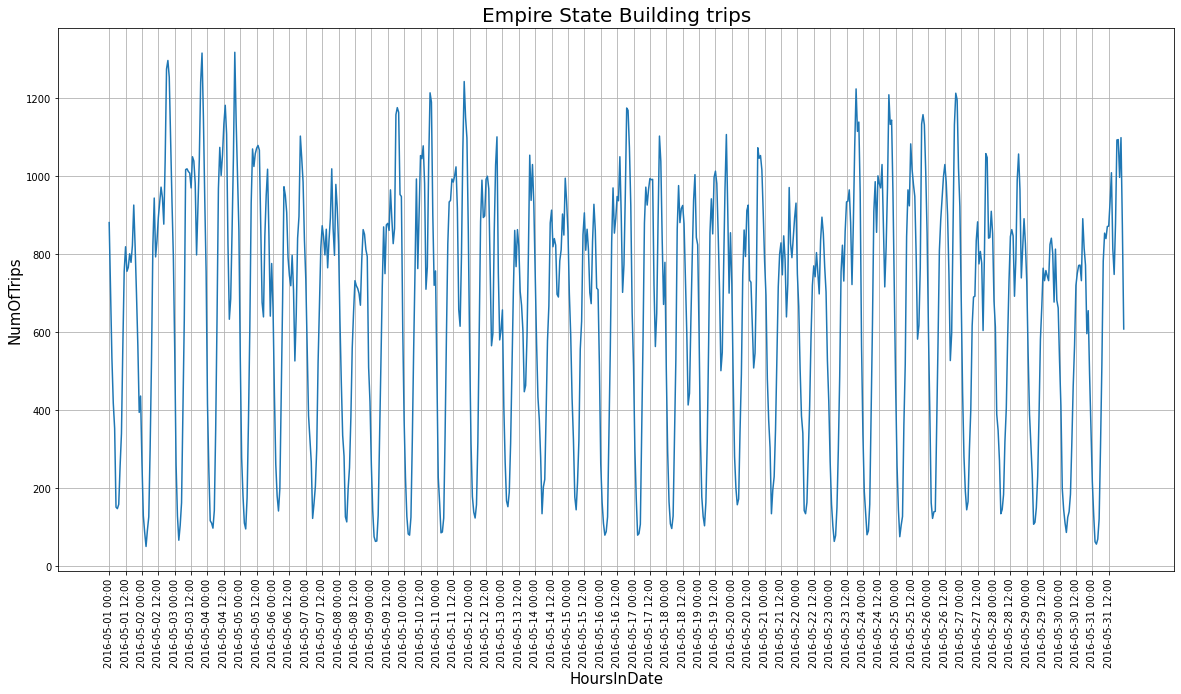

In [107]:
# Точка Empire State Building. Ограничим наши поездки
longitude = -73.985428
latitude = 40.748817

row = count_data[(count_data.west <= longitude) & 
                 (count_data.east >= longitude) & 
                 (count_data.south <= latitude) & 
                 (count_data.north >= latitude)]

trips = np.array(row.iloc[0, 5:])
hours = list(range(len(trips)))

# Парсинг даты для лейблов на графике
labels = [datetime.datetime.strptime(i, '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d %H:%M') for i in list(row.columns[5:])]
plt.figure(figsize=(20, 10))
plt.plot(hours, trips)

plt.xlabel('HoursInDate', fontsize=15)
# Будут указаны интервалы одного дня (от 00:00 до 12:00)
plt.xticks(hours[::12], labels[::12], rotation='vertical')

plt.ylabel('NumOfTrips', fontsize=15)
plt.title('Empire State Building trips', fontsize=20)
plt.grid(True)
plt.show()

### Нули
Посчитайте, сколько в мае 2016 было пар час-ячейка, для которых не было совершено ни одной поездки.

In [127]:
data = np.array(count_data.iloc[:, 5:])
num_of_zeros = data.size - np.count_nonzero(data)
print(f'Всего в мае 2016 года {data.size} пар час-ячейка.\nИз них {num_of_zeros} - нулевые, т.е. \
                              {(num_of_zeros / data.size) * 100 :.0f}%')

Всего в мае 2016 года 1860000 пар час-ячейка.
Из них 1718238 - нулевые, т.е. 92%
